In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model_conv import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [4]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float) / 255.0
    test_X = test_X.astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [5]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] +1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])

# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


# And now multple input channels!
X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

Shape of X: (2, 2, 2, 1)
Shape of W (2, 2, 1, 1)
Shape of X: (2, 2, 2, 2)


In [6]:
# First test - check the shape is right
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


In [7]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)


Gradient check passed!


In [8]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)

assert check_layer_gradient(pool, X)



Gradient check passed!


In [9]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

Gradient check passed!


In [10]:
# TODO: In model.py, implement missed functions function for ConvNet model

# No need to use L2 regularization
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!
Checking gradient for W3
Gradient check passed!
Checking gradient for B3
Gradient check passed!


True

In [11]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-4)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.302694, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302659, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302625, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302590, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302556, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302521, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302487, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302452, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302418, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302383, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302349, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302314, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302280, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302245, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302211, Train accuracy: 0.062500, val accuracy: 0.000000
Loss: 2.302176, Train acc

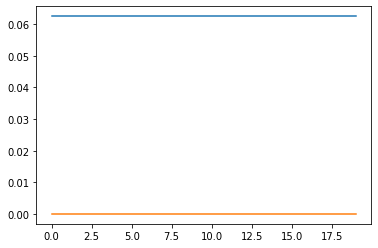

In [12]:
plt.plot(train_history)
plt.plot(val_history)

In [41]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=3, conv2_channels=3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=1, num_epochs=20, batch_size=64)

loss_history, train_history, val_history = trainer.fit()



Loss: 2.305242, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.287696, Train accuracy: 0.156250, val accuracy: 0.093750
Loss: 2.287327, Train accuracy: 0.187500, val accuracy: 0.250000
Loss: 2.337153, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.229412, Train accuracy: 0.156250, val accuracy: 0.093750
Loss: 2.269440, Train accuracy: 0.203125, val accuracy: 0.242188
Loss: 2.287129, Train accuracy: 0.187500, val accuracy: 0.226562
Loss: 2.211274, Train accuracy: 0.148438, val accuracy: 0.062500
Loss: 2.215230, Train accuracy: 0.187500, val accuracy: 0.250000
Loss: 2.351107, Train accuracy: 0.195312, val accuracy: 0.218750
Loss: 2.250535, Train accuracy: 0.179688, val accuracy: 0.125000
Loss: 2.253449, Train accuracy: 0.195312, val accuracy: 0.210938
Loss: 2.227093, Train accuracy: 0.171875, val accuracy: 0.250000
Loss: 2.219715, Train accuracy: 0.187500, val accuracy: 0.109375
Loss: 2.238069, Train accuracy: 0.242188, val accuracy: 0.218750
Loss: 2.139072, Train acc

In [38]:
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=1, num_epochs=20, batch_size=64)

loss_history, train_history, val_history = trainer.fit()


Loss: 2.260800, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.175084, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.161721, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.227841, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.181467, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.266383, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.259553, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.202524, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.228290, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.196900, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.276017, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.232297, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.238008, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.238758, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.261645, Train accuracy: 0.179688, val accuracy: 0.250000
Loss: 2.169731, Train acc

In [ ]:
plt.plot(train_history)
plt.plot(val_history)